In [1]:
import os
import time

import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from tqdm import tqdm

import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [2]:
SCALING_FACTOR = 4
CROP_DIM = 648

In [3]:
hr_dir = 'DIV2K_valid_HR/'

In [2]:
class DIV2KDataset(Dataset):
    def __init__(self, path, transform=None):
        self.hr_dir = path
        self.img_list = os.listdir(path)
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        hr = Image.open(self.hr_dir+self.img_list[idx])
        
        # Randomly crop image
        w, h = hr.size
        rand_w = np.random.randint(0, w-CROP_DIM)
        rand_h = np.random.randint(0, h-CROP_DIM)
        
        hr = hr.crop((rand_w, rand_h, rand_w+CROP_DIM, rand_h+CROP_DIM))
        
        # Transforms
        if self.transform:
            hr = self.transform(hr)
        
        # Resize to create LR image
        lr = hr.resize((CROP_DIM//SCALING_FACTOR, CROP_DIM//SCALING_FACTOR), Image.BICUBIC)
#         display(hr)
#         display(lr)
        
        # Images to tensors
        hr = transforms.ToTensor()(hr) - 0.5
        lr = transforms.ToTensor()(lr) - 0.5
        
        return lr, hr

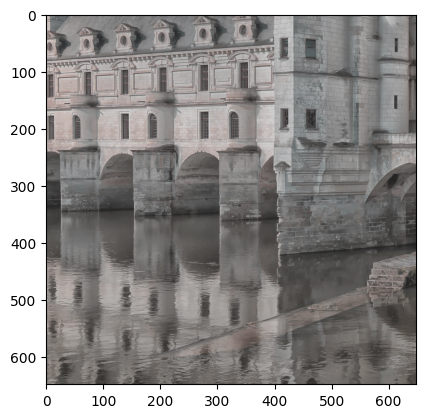

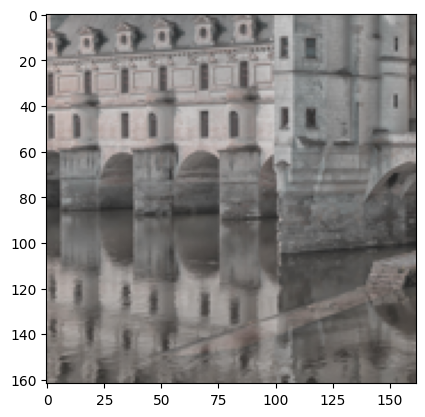

In [5]:
transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.6, 0.1)
])

ds = DIV2KDataset('DIV2K_valid_HR/', transform=transform)
for lr, hr in ds:
    plt.imshow(hr.permute(1, 2, 0).detach().numpy()+0.5)
    plt.show()
    plt.imshow(lr.permute(1, 2, 0).detach().numpy()+0.5)
    break

In [6]:
dl = DataLoader(ds, batch_size=4, shuffle=True)
for lr, hr in tqdm(dl):
    print(hr.shape, lr.shape)
    break

  0%|                                                    | 0/25 [00:00<?, ?it/s]

torch.Size([4, 3, 648, 648]) torch.Size([4, 3, 162, 162])


In [3]:
class PSNR(nn.Module):
    def __init__(self, R=1):
        super(PSNR, self).__init__()
        self.R = torch.tensor(R)
        
    def forward(self, mse):
        return 10*torch.log10((torch.square(self.R)/mse))

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.d, self.s, self.m = 56, 12, 4
        
        self.conv1 = nn.Conv2d(3, self.d, kernel_size=5, padding=5//2)
        self.conv2 = nn.Conv2d(self.d, self.s, kernel_size=1)
        self.conv_m = nn.Sequential(*[
            nn.Conv2d(self.s, self.s, kernel_size=3, padding=3//2), nn.ReLU()
        ]*self.m)
        self.conv3 = nn.Conv2d(self.s, self.d, kernel_size=1)
        
        self.deconv1 = nn.ConvTranspose2d(self.d, 3, kernel_size=9,stride=SCALING_FACTOR,
                                          padding=9//2, output_padding=SCALING_FACTOR-1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        
        x = self.conv_m(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        
        x = self.deconv1(x)
        return x
    
    def get_conv(self, m):
        conv = nn.Sequential([nn.Conv2d(self.s, self.s, 3)]*m)

In [9]:
model = Model()
model(lr).shape

torch.Size([4, 3, 648, 648])

In [10]:
psnr = PSNR()
mse = nn.MSELoss()

output = model(lr).detach()
print(output.min(), output.max(), '--')
mse_ = mse(output, hr)
print(mse_)

psnr_ = psnr(mse_)
psnr_

tensor(-0.1019) tensor(0.1599) --
tensor(0.0775)


tensor(11.1045)

### Training

In [4]:
SCALING_FACTOR = 4
CROP_DIM = 648

BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 0.001

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.6, 0.1)
])

train_ds = DIV2KDataset('DIV2K_valid_HR/', transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

valid_ds = DIV2KDataset('DIV2K_valid_HR/', transform=transform)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)


model = Model()

In [14]:
criterion = nn.MSELoss()
metric = PSNR()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

start = time.time()

model.to(device) # GPU
model.train()

for epoch in range(1, EPOCHS+1):
    print('\nEPOCH =', epoch)
    
    # TRAINING
    loss, psnr = 0, 0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss_ = criterion(outputs, labels)
        loss_.backward()
        optimizer.step()
        
        loss += loss_.item()
        psnr += metric(loss_.item())
        
        
    with torch.no_grad():
        model.eval()
        
        # VALIDATION
        v_tloss, v_psnr = 0, 0
        for i, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data[0].to(device), data[1].to(device) # GPU

            outputs = model(inputs).detach()
            loss_ = criterion(outputs, labels)

            v_tloss += loss_.item()
            v_psnr += metric(loss_.item())
        
        
        
    print(f'Train_MSE: {loss/len(train_loader):.4f}  |  Valid_MSE: {v_tloss/len(valid_loader):.4f}')
    print(f'Train_PSNR: {psnr/len(train_loader):.4f}  |  Valid_PSNR: {v_psnr/len(valid_loader)}')
    
    
        
#         break


EPOCH = 1


  0%|                                                    | 0/25 [00:00<?, ?it/s]

tensor(0.0902, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|█▊                                          | 1/25 [00:20<08:10, 20.45s/it]

tensor(0.0902, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0902, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|███▌                                        | 2/25 [00:21<03:21,  8.77s/it]

tensor(0.0716, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0716, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0716, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█████▎                                      | 3/25 [00:21<01:50,  5.01s/it]

tensor(0.1108, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1108, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1108, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|███████                                     | 4/25 [00:22<01:10,  3.38s/it]

tensor(0.0951, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0951, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0951, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|████████▊                                   | 5/25 [00:23<00:49,  2.48s/it]

tensor(0.0744, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0744, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0744, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██████████▌                                 | 6/25 [00:23<00:34,  1.84s/it]

tensor(0.0985, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0985, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0985, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|████████████▎                               | 7/25 [00:24<00:25,  1.44s/it]

tensor(0.0592, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0592, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0592, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|██████████████                              | 8/25 [00:25<00:19,  1.17s/it]

tensor(0.1228, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1228, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1228, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|██████████████                              | 8/25 [00:25<00:53,  3.17s/it]


KeyboardInterrupt: 

In [ ]:
for lr, hr in train_loader:
    lr, hr = lr+0.5, hr+0.5
    plt.imshow(lr[0].permute(1, 2, 0))
    plt.show()
    lr = lr.to(device)
    img = model(lr)[0].permute(1, 2, 0).cpu().detach().numpy()
#     img = (img-img.min())/(img.max()-img.min())
    print(img.min(), img.max())
#     img += 0.5
    plt.imshow(img)
    plt.show()
    print(img.min(), img.max())
    break

### MLFlow

In [7]:
import mlflow
import lightning as pl
from torch.nn import functional as F

In [34]:
metric = PSNR()

class FSRCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.d, self.s, self.m = 56, 12, 4
        
        self.model = nn.Sequential(
            nn.Conv2d(3, self.d, kernel_size=5, padding=5//2),
            nn.ReLU(),
            nn.Conv2d(self.d, self.s, kernel_size=1),
            nn.ReLU()
        )
        
        for _ in range(self.m):
            self.model.append(nn.Conv2d(self.s, self.s, kernel_size=3, padding=3//2)),
            self.model.append(nn.ReLU())
            
        self.model.append(nn.Conv2d(self.s, self.d, kernel_size=1))
        self.model.append(nn.ReLU())
        
        self.model.append(nn.ConvTranspose2d(self.d, 3, kernel_size=9,stride=SCALING_FACTOR,
                                          padding=9//2, output_padding=SCALING_FACTOR-1))
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        psnr = metric(loss.item())
        
        self.log('train_mse', loss, on_epoch=True)
        self.log('train_psnr', psnr, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.model.parameters(), lr=LEARNING_RATE)

In [35]:
model = FSRCNN()

transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.6, 0.1)
])

train_ds = DIV2KDataset('DIV2K_valid_HR/', transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=12, shuffle=True)

trainer = pl.Trainer(max_epochs=3)

mlflow.pytorch.autolog()

with mlflow.start_run() as run:
    trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/10/23 22:42:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24.5 K
-------------------------------------
24.5 K    Trainable params
0         Non-trainable params
24.5 K    Total params
0.098     Total estimated model params size (MB)


Epoch 2: 100%|█████████████████████████| 25/25 [00:03<00:00,  6.56it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|█████████████████████████| 25/25 [00:03<00:00,  6.51it/s, v_num=2]


2023/10/23 22:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pytorch autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


In [33]:
# mlflow.get_run(run_id=run.info.run_id)

In [37]:
!pip list

Package                      Version     
---------------------------- ------------
absl-py                      1.4.0       
aiohttp                      3.8.6       
aiosignal                    1.3.1       
albumentations               1.3.1       
alembic                      1.12.0      
anyio                        4.0.0       
argon2-cffi                  23.1.0      
argon2-cffi-bindings         21.2.0      
asttokens                    2.4.0       
astunparse                   1.6.3       
async-lru                    2.0.4       
async-timeout                4.0.3       
attrs                        23.1.0      
Babel                        2.12.1      
backcall                     0.2.0       
beautifulsoup4               4.12.2      
black                        23.10.0     
bleach                       6.0.0       
blinker                      1.6.3       
cachetools                   5.3.1       
certifi                      2023.7.22   
cffi                         1.15.

In [36]:
!mlflow ui

[2023-10-23 22:42:55 +0530] [48116] [INFO] Starting gunicorn 21.2.0
[2023-10-23 22:42:55 +0530] [48116] [INFO] Listening at: http://127.0.0.1:5000 (48116)
[2023-10-23 22:42:55 +0530] [48116] [INFO] Using worker: sync
[2023-10-23 22:42:55 +0530] [48124] [INFO] Booting worker with pid: 48124
[2023-10-23 22:42:55 +0530] [48125] [INFO] Booting worker with pid: 48125
[2023-10-23 22:42:55 +0530] [48132] [INFO] Booting worker with pid: 48132
[2023-10-23 22:42:55 +0530] [48133] [INFO] Booting worker with pid: 48133
^C
[2023-10-23 22:43:18 +0530] [48116] [INFO] Handling signal: int
[2023-10-23 22:43:18 +0530] [48125] [INFO] Worker exiting (pid: 48125)
[2023-10-23 22:43:18 +0530] [48132] [INFO] Worker exiting (pid: 48132)
[2023-10-23 22:43:18 +0530] [48124] [INFO] Worker exiting (pid: 48124)
[2023-10-23 22:43:18 +0530] [48133] [INFO] Worker exiting (pid: 48133)
